In [230]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from pandas_datareader.data import DataReader
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import math
# import sys
# sys.path.append(r'C:\\Users\\tintin\\AppData\\Local\\Programs\\Python\\Python37\\Library\\bin')
import cvxopt as opt
from cvxopt import blas, solvers
from yahoofinancials import YahooFinancials
import prettytable
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
from scipy.stats.mstats import gmean
%pylab inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
import glob 
warnings.simplefilter(action='ignore')
pio.renderers.default = 'iframe'
import ipywidgets as widgets
pyo.init_notebook_mode(connected = True)
from ipywidgets import interactive, HBox, VBox, widgets, interact
from ipywidgets import FloatSlider

Populating the interactive namespace from numpy and matplotlib


In [3]:
train_start = '1960-03-31'
train_end = '2005-12-31'

test_start = '2006-03-31'
test_end = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d') #'2020-06-30'
gdp_train_model_start = (datetime.strptime(train_start, '%Y-%m-%d') - timedelta(days=520))
gdp_test_model_start = (datetime.strptime(test_start, '%Y-%m-%d') - timedelta(days=520))

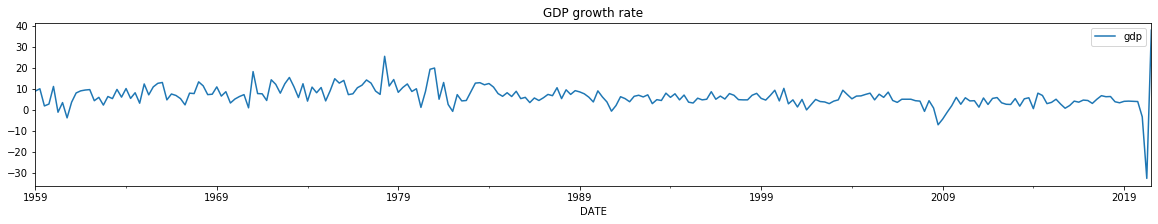

In [4]:
usrec = DataReader('USREC', 'fred', start=(datetime.strptime(train_start, '%Y-%m-%d') - timedelta(days=366)))
usrec = usrec.resample('Q').max()
gdp = DataReader('A191RP1Q027SBEA', 'fred', start=gdp_train_model_start)
gdp = gdp.resample('Q', convention = 'end').max()
gdp.rename(columns={'A191RP1Q027SBEA':'gdp'},inplace=True)
gdp.plot(title='GDP growth rate', figsize=(20,3));

In [5]:
equity = yf.download('^GSPC',interval = '1mo',period='max')
equity['equity_ret'] = equity['Adj Close'].pct_change()
equity.index = pd.to_datetime(equity.index)

bond = yf.download('^IRX',interval = '1mo',period='max')
bond['bond_ret'] = bond['Adj Close'].pct_change()
bond.index = pd.to_datetime(bond.index)

forex = yf.download('DX-Y.NYB',interval = '1mo',period='max')
forex['forex_ret'] = forex['Adj Close'].pct_change()
forex.index = pd.to_datetime(forex.index)

gc = pd.read_csv('gc.csv',parse_dates=True)
gc['gc_ret'] = gc.adj_close.pct_change()
gc['date']= pd.to_datetime(gc.date)
gc.set_index('date', inplace=True)
gc = gc.fillna('0')


asset_month_ret = pd.concat([equity,bond,gc],axis=1, join='inner')
asset_month_ret = asset_month_ret.loc[:,['equity_ret','bond_ret','gc_ret']]


equity = equity.resample('Q').ffill()
gc = gc.resample('Q').ffill()
bond = bond.resample('Q').ffill()

combined = pd.concat([equity,bond,gc],axis=1, join='inner')
combined = combined.loc[:,['equity_ret','bond_ret','gc_ret']]

combined['equity_ret_2'] = combined['equity_ret'].shift(2)
combined['bond_ret_2'] = combined['bond_ret'].shift(2)
combined['gc_ret_2'] = combined['gc_ret'].shift(2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
combined.head()

,equity_ret,bond_ret,gc_ret,equity_ret_2,bond_ret_2,gc_ret_2
1960-03-31,-0.013899,-0.279236,0,NaN,NaN,NaN
1960-06-30,0.019523,-0.298077,-0.0002849,NaN,NaN,NaN
1960-09-30,-0.060393,-0.105058,0.00256191,-0.013899,-0.279236,0
1960-12-31,0.046273,-0.083333,-0.00781686,0.019523,-0.298077,-0.0002849
1961-03-31,0.025536,-0.062015,-0.002559,-0.060393,-0.105058,0.00256191


In [7]:
asset_month_ret.head()

,equity_ret,bond_ret,gc_ret
1960-01-01,-0.071464,NaN,0.00114123
1960-02-01,0.009171,0.050125,0
1960-03-01,-0.013899,-0.279236,0
1960-04-01,-0.017528,0.006623,0.000569963
1960-05-01,0.026853,0.026316,-0.000284819


In [8]:
def calc_num(x): return int(x[1] >= 0.15)
def calc_num_new(x): return int( x[1] >= 0.10)

In [9]:
gdp_train = gdp.fillna(method='ffill')[gdp_train_model_start:train_end] # need to go order unit back(4 quarter) for begda
gdp_test = gdp.fillna(method='ffill')[gdp_test_model_start:test_end] # need to go order unit back(4 quarter) for begda

In [10]:
#Fit the model
mod_kns = sm.tsa.MarkovAutoregression(gdp_train,k_regimes=2,order=4,switching_ar=False,switching_variance=True,
                                           trend = 'nc');
res_hamilton = mod_kns.fit()
df_regime = res_hamilton.filtered_marginal_probabilities
df_regime.index.feq = 'QS'
df_regime['regime'] = df_regime.apply(calc_num, axis=1)

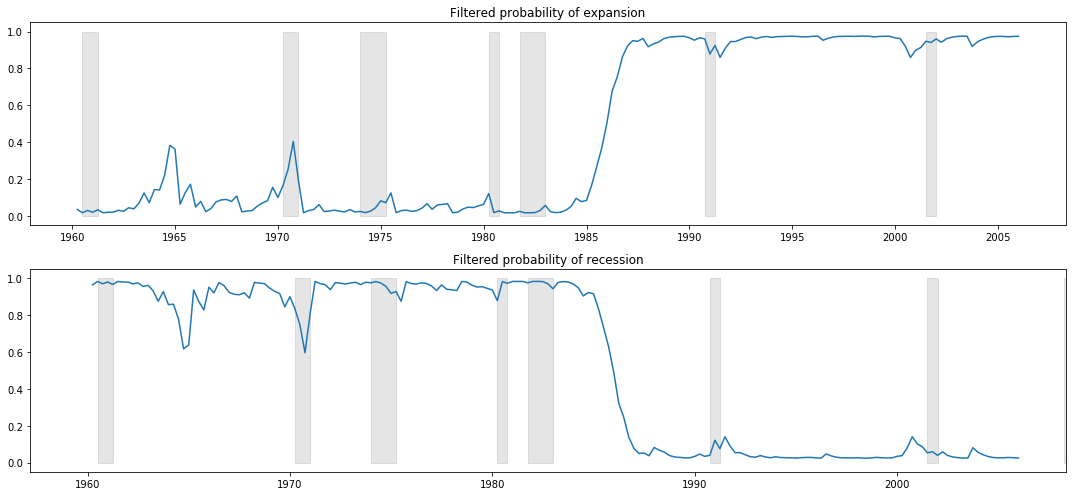

In [11]:
fig, axes = plt.subplots(2, figsize=(15,7))
usrec_train = usrec[train_start:train_end]
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec_train.index, 0, 1, where=usrec_train['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of expansion')
ax = axes[1]
ax.plot(res_hamilton.filtered_marginal_probabilities[1])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of recession')

fig.tight_layout()

## We Observe from Filtered Probability of Recession that there was a change in perception from 1982 onwards where probability of recession is lowered to less that 0.2 level. This means the  the tolerence of economies going into recession has increased.

In [12]:
print(r"1960-2005 @ 0.15 Tolerance Level Number of Recession = {} and Number of Expansion = {}".format(len(df_regime[df_regime.regime==1]), len(df_regime[df_regime.regime==0])))

1960-2005 @ 0.15 Tolerance Level Number of Recession = 106 and Number of Expansion = 78


In [13]:
#Fit the model
mod_kns_test = sm.tsa.MarkovAutoregression(gdp_test,k_regimes=2,order=4,switching_ar=False,switching_variance=True,
                                           trend = 'nc')
res_hamilton_test = mod_kns_test.fit()
df_regime_test = res_hamilton_test.filtered_marginal_probabilities
df_regime_test.index.feq = 'QS'
df_regime_test['regime'] = df_regime_test.apply(calc_num_new, axis=1)

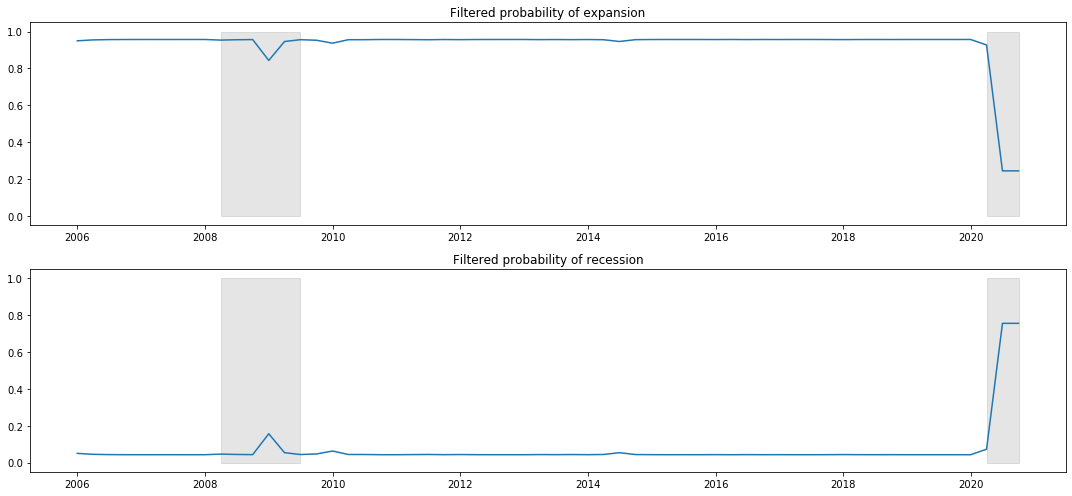

In [14]:
fig, axes = plt.subplots(2, figsize=(15,7))
usrec_test = usrec[test_start:test_end]
ax = axes[0]
ax.plot(res_hamilton_test.filtered_marginal_probabilities[0])
ax.fill_between(usrec_test.index, 0, 1, where=usrec_test['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of expansion')

ax = axes[1]
ax.plot(res_hamilton_test.filtered_marginal_probabilities[1])
ax.fill_between(usrec_test.index, 0, 1, where=usrec_test['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of recession')

fig.tight_layout()

## We Observe from Filtered Probability of Recession that there was a change in perception from 1982 onwards where probability of recession is lowered to less that 0.1 level. This means the the tolerence of economies going into recession has increased.

In [15]:
print(r"2006-2020 @ 0.10 Tolerance Level Number of Recession = {} and Number of Expansion = {}".format(len(df_regime_test[df_regime_test.regime==1]), len(df_regime_test[df_regime_test.regime==0])))

2006-2020 @ 0.10 Tolerance Level Number of Recession = 3 and Number of Expansion = 57


In [16]:
y_test = df_regime_test['regime']
y_test.head()

DATE
2005-12-31    0
2006-03-31    0
2006-06-30    0
2006-09-30    0
2006-12-31    0
Freq: Q-DEC, Name: regime, dtype: int64

In [17]:
classifier_X = gdp.copy()
classifier_X['gdp_lag_1'] = classifier_X['gdp'].shift(1)
classifier_X['gdp_lag_2'] = classifier_X['gdp'].shift(2)
classifier_X['gdp_lag_3'] = classifier_X['gdp'].shift(3)
classifier_X['gdp_lag_4'] = classifier_X['gdp'].shift(4)

classifier_X['equity_ret_2'] = combined['equity_ret_2']
classifier_X['bond_ret_2'] = combined['bond_ret_2']
classifier_X['gc_ret_2'] = combined['gc_ret_2']

train_x = classifier_X[['gdp_lag_1','gdp_lag_2','gdp_lag_3','gdp_lag_4','equity_ret_2','bond_ret_2','gc_ret_2']]
test_x = classifier_X[['gdp_lag_1','gdp_lag_2','gdp_lag_3','gdp_lag_4','equity_ret_2','bond_ret_2','gc_ret_2']]

train_x = train_x[train_start:train_end].fillna(0)
test_x = test_x[test_start:test_end].fillna(0)

In [18]:
train_x.head()

,gdp_lag_1,gdp_lag_2,gdp_lag_3,gdp_lag_4,equity_ret_2,bond_ret_2,gc_ret_2
DATE,,,,,,,
1960-03-31,2.7,1.8,10.0,8.9,0.000000,0.000000,0.000000
1960-06-30,11.1,2.7,1.8,10.0,0.000000,0.000000,0.000000
1960-09-30,-1.2,11.1,2.7,1.8,-0.013899,-0.279236,0.000000
1960-12-31,3.4,-1.2,11.1,2.7,0.019523,-0.298077,-0.000285
1961-03-31,-3.9,3.4,-1.2,11.1,-0.060393,-0.105058,0.002562


In [19]:
train_y = df_regime['regime']
train_y.head()

DATE
1960-03-31    1
1960-06-30    1
1960-09-30    1
1960-12-31    1
1961-03-31    1
Freq: Q-DEC, Name: regime, dtype: int64

In [20]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.1, max_depth = 3, random_state = 0)
gb.fit(train_x,train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
train_x

,gdp_lag_1,gdp_lag_2,gdp_lag_3,gdp_lag_4,equity_ret_2,bond_ret_2,gc_ret_2
DATE,,,,,,,
1960-03-31,2.7,1.8,10.0,8.9,0.000000,0.000000,0.000000
1960-06-30,11.1,2.7,1.8,10.0,0.000000,0.000000,0.000000
1960-09-30,-1.2,11.1,2.7,1.8,-0.013899,-0.279236,0.000000
1960-12-31,3.4,-1.2,11.1,2.7,0.019523,-0.298077,-0.000285
1961-03-31,-3.9,3.4,-1.2,11.1,-0.060393,-0.105058,0.002562
...,...,...,...,...,...,...,...
2004-12-31,6.6,6.5,5.2,7.2,0.017989,0.238593,0.020385
2005-03-31,7.3,6.6,6.5,5.2,0.009364,0.067602,0.013168
2005-06-30,7.9,7.3,6.6,6.5,0.032458,0.000000,0.008917


In [22]:
train_y

DATE
1960-03-31    1
1960-06-30    1
1960-09-30    1
1960-12-31    1
1961-03-31    1
             ..
2004-12-31    0
2005-03-31    0
2005-06-30    0
2005-09-30    0
2005-12-31    0
Freq: Q-DEC, Name: regime, Length: 184, dtype: int64

In [23]:
pred_train_y = gb.predict(train_x)

In [24]:
pred_train_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [25]:
train_y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
print("Confusion Matrix between Y_Train and Predicted Y Train:")
print(confusion_matrix(train_y, pred_train_y))
print()
print("Classification Report")
print(classification_report(train_y, pred_train_y))

Confusion Matrix between Y_Train and Predicted Y Train:
[[ 78   0]
 [  0 106]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       106

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [27]:
gdp_all = gdp.fillna(method='ffill')['1959-03-31':test_end]
#Fit the model
mod_kns_all = sm.tsa.MarkovAutoregression(gdp_all,k_regimes=2,order=4,switching_ar=False,switching_variance=True,
                                           trend = 'nc');
res_hamilton_all = mod_kns_all.fit()
df_regime_all = res_hamilton_all.filtered_marginal_probabilities
df_regime_all.index.feq = 'QS'
df_regime_all['regime'] = df_regime_all.apply(calc_num_new, axis=1)

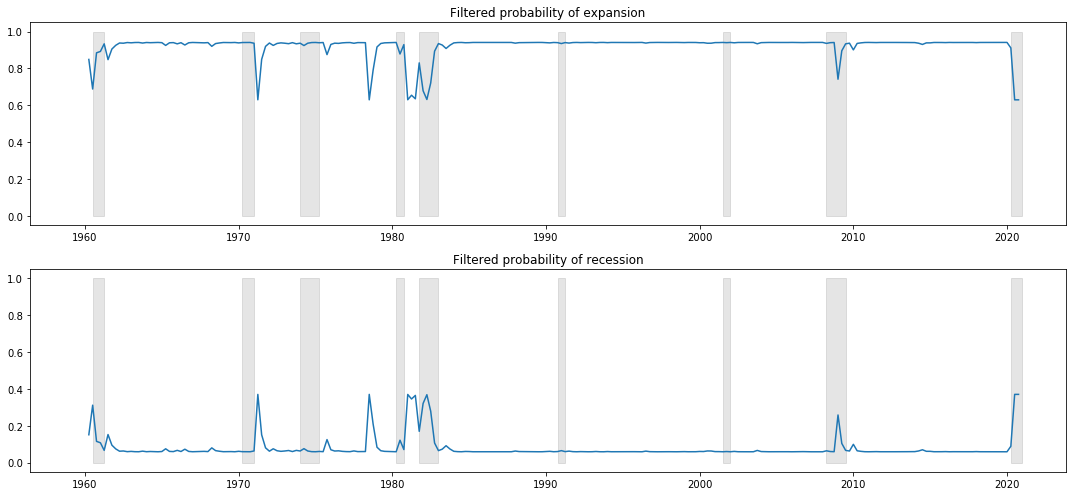

In [28]:
fig, axes = plt.subplots(2, figsize=(15,7))

ax = axes[0]
ax.plot(res_hamilton_all.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of expansion')

ax = axes[1]
ax.plot(res_hamilton_all.filtered_marginal_probabilities[1])
ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='k',alpha=0.1)
ax.set(title='Filtered probability of recession')

fig.tight_layout()

In [29]:
print(r"1960-2020 @ 0.10 Tolerance Level Number of Recession = {} and Number of Expansion = {}".format(len(df_regime_all[df_regime_all.regime==1]), len(df_regime_all[df_regime_all.regime==0])))

1960-2020 @ 0.10 Tolerance Level Number of Recession = 23 and Number of Expansion = 220


In [30]:
y_test_all = df_regime_all[['regime']][test_start:test_end]
pred_test_y = gb.predict(test_x)

In [31]:
pred_test_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [32]:
print("Confusion Matrix(all):")
print(confusion_matrix(y_test_all, pred_test_y))
print()
print("Classification Report(all)")
print(classification_report(y_test_all, pred_test_y))

Confusion Matrix(all):
[[52  3]
 [ 2  2]]

Classification Report(all)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        55
           1       0.40      0.50      0.44         4

    accuracy                           0.92        59
   macro avg       0.68      0.72      0.70        59
weighted avg       0.92      0.92      0.92        59



## Create Portfolio---WIP

In [95]:
# import sys
# sys.path.append(r'C:\\Users\\tintin\\AppData\\Local\\Programs\\Python\\Python37\\Library\\bin')
# import cvxopt as opt
def optimal_portfolio(returns, S):
    n = len(returns)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]
    # Convert to cvxopt matrices
    pbar = opt.matrix(returns)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = []
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = []
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    risks = [(sum(risks) / len(risks)) if math.isnan(x) else x for x in risks]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(abs(m1[2] / m1[0]))
    # CALCULATE THE OPTIMAL PORTFOLIO
    solvers.options['show_progress'] = False
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios

In [96]:
def find_weights(RISK, PORTFOLIOS, tgt_risk):
    '''
    RISK is a np.array() of risk levels
    RETURN is a np.array() of associated optimum returns
    Portfolios is weights
    '''
    assert len(RISK) == len(PORTFOLIOS)
    last = None
    for (risk, w) in zip(RISK, PORTFOLIOS):
        if risk > tgt_risk:
            return last
        last = w
    return last

In [100]:
qtr_ret = pd.concat([equity,bond,gc],axis=1, join='inner')
qtr_ret = qtr_ret.loc[:,['equity_ret','bond_ret','gc_ret']][test_start:test_end]
qtr_ret['quarter'] = qtr_ret.index.year.astype(str) + '-' + qtr_ret.index.quarter.astype(str)
qtr_ret['pred_test_y'] = pred_test_y

cov_0 = np.ravel(qtr_ret[qtr_ret.pred_test_y == 0].reset_index()[['equity_ret','bond_ret','gc_ret']].astype(np.float).cov())
cov_1 = np.ravel(qtr_ret[qtr_ret.pred_test_y == 1].reset_index()[['equity_ret','bond_ret','gc_ret']].astype(np.float).cov())

In [101]:
cov_mat = []
cov_mat += [cov_0[[0,3,4,6,7,8]]] 
cov_mat += [cov_1[[0,3,4,6,7,8]]] 
cov_mat = pd.DataFrame(cov_mat,index =['expansion', 'recession'], 
                                              columns =['equity_var', 'equity_bond_cov', 'bond_var','equity_gold_cov','bond_gold_cov','gold_var'])
cov_mat.index.name = 'regime'

In [102]:
cov_mat

,equity_var,equity_bond_cov,bond_var,equity_gold_cov,bond_gold_cov,gold_var
regime,,,,,,
expansion,0.001654,0.000705,1.053355,0.000196,0.000092,0.001291
recession,0.001337,-0.035018,4.338428,-0.000836,0.071235,0.001286


In [103]:
# covariance matrix from linear regression model
def get_covar_matrix(x):
    X = np.array([x['equity_var'], x['equity_bond_cov'],x['equity_gold_cov'],
                  x['equity_bond_cov'],x['bond_var'],x[ 'bond_gold_cov'],
                  x['equity_gold_cov'],x[ 'bond_gold_cov'],x['gold_var']])
    return opt.matrix(X,(3,3))

Cov_matrix = []
for i in range(len(cov_mat)):
    cov_matrix = get_covar_matrix(cov_mat.to_dict('records')[i])
    Cov_matrix += [cov_matrix]

In [177]:
month_ret = asset_month_ret.copy()
month_ret = month_ret.loc[:,['equity_ret','bond_ret','gc_ret']][train_end:test_end]
month_ret['quarter'] = month_ret.index.year.astype(str) + '-' + month_ret.index.quarter.astype(str)
month_ret.index.name = 'date'
month_ret_regime = pd.merge(left=month_ret.reset_index(), right=qtr_ret.reset_index(), left_on='quarter',
                              right_on='quarter').set_index(['date'])
month_ret_regime = month_ret_regime.drop(['index','equity_ret_y','bond_ret_y','gc_ret_y','quarter'], axis = 1)
month_ret_regime_expansion = month_ret_regime[month_ret_regime.pred_test_y == 0].copy().drop(['pred_test_y'], axis = 1)
month_ret_regime_recession = month_ret_regime[month_ret_regime.pred_test_y == 1].copy().drop(['pred_test_y'], axis = 1)

In [178]:
weights_expansion, returns_expansion, risks_expansion, portfolios_expansion = optimal_portfolio(month_ret_regime_expansion.iloc[0], Cov_matrix[0])
weights_recession, returns_recession, risks_recession, portfolios_recession = optimal_portfolio(month_ret_regime_recession.iloc[0], Cov_matrix[1])

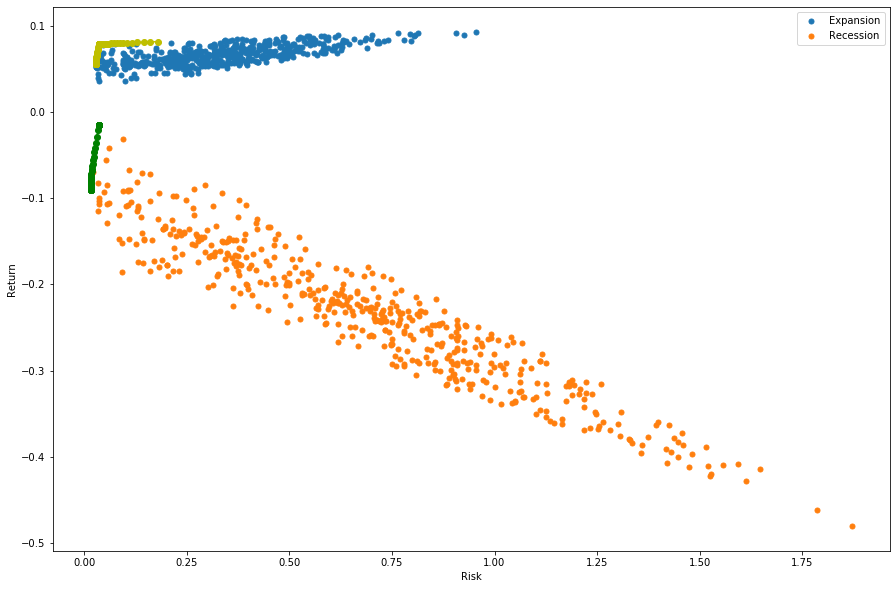

In [179]:

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns,cov):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(returns)
    w = np.asmatrix(rand_weights(3))
    C = np.asmatrix(cov)
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_portfolios = 500
means_expansion, stds_expansion = np.column_stack([
    random_portfolio(month_ret_regime_expansion.iloc[0].values,Cov_matrix[0]) 
    for _ in range(n_portfolios)
])

n_portfolios = 500
means_recession, stds_recession = np.column_stack([
    random_portfolio(month_ret_regime_recession.iloc[0].values,Cov_matrix[1]) 
    for _ in range(n_portfolios)
])

fig = plt.figure(figsize=[15,10])
plt.plot(stds_expansion, means_expansion, 'o',markersize=5,label='Expansion')
plt.plot(stds_recession, means_recession, 'o', markersize=5,label='Recession')
plt.ylabel('Return')
plt.xlabel('Risk')
plt.plot(risks_expansion, returns_expansion, 'y-o')
plt.plot(risks_recession, returns_recession, 'g-o')
plt.legend()
plt.show()

In [244]:
def buildweight(inputstage1, df_daily_ret_act,lookback):
    mean_lookback_returns = []
    quarterly_cov_hat = []
    sub = df_daily_ret_act.tail(lookback)
    return_vec = sub[['equity_ret_x', 'bond_ret_x', 'gc_ret_x']].mean().values
    sigma = inputstage1
    mean_lookback_returns += [return_vec]
    quarterly_cov_hat += [sigma]
    risks = []
    weights = []
    for ret, cov in zip(mean_lookback_returns, quarterly_cov_hat):
        w, re, ri, p = optimal_portfolio(ret, cov)
        risks += [ri]
        weights += [p]
    table = {}
    weights_table = [] 
    table = {'risks': risks[0], 'weights': weights[0]}
    table = pd.DataFrame(table)
    table = table.sort_values(by=['risks'])
    low_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.1))
    med_w = find_weights(table.risks, table.weights, table.risks.quantile(q=0.5))
    high_w = find_weights(table.risks, table.weights,table.risks.quantile(q=0.9))
    g = {'equity_low_w_hat': float(low_w[0]),
             'bond_low_w_hat': float(low_w[1]),
             'gold_low_w_hat': float(low_w[2]),
             'equity_med_w_hat': float(med_w[0]),
             'bond_med_w_hat': float(med_w[1]),
             'gold_med_w_hat': float(med_w[2]),
             'equity_high_w_hat': float(high_w[0]),
             'bond_high_w_hat': float(high_w[1]),
             'gold_high_w_hat': float(high_w[2])}
    weights_table += [g]
    weights_table = pd.DataFrame(weights_table)
    weights_table = weights_table.fillna('0')
    return weights_table

In [245]:
weights_table_expansion = buildweight(Cov_matrix[0], month_ret_regime_expansion,12)
weights_table_recession = buildweight(Cov_matrix[1], month_ret_regime_recession,12)

In [182]:
weights_table_expansion.iloc[0]

equity_low_w_hat     4.270936e-01
bond_low_w_hat       4.549276e-04
gold_low_w_hat       5.724514e-01
equity_med_w_hat     2.693781e-01
bond_med_w_hat       1.659641e-03
gold_med_w_hat       7.289623e-01
equity_high_w_hat    1.358594e-07
bond_high_w_hat      9.687440e-02
gold_high_w_hat      9.031255e-01
Name: 0, dtype: float64

In [183]:
weights_table_recession.iloc[0]

equity_low_w_hat     4.932509e-01
bond_low_w_hat       3.288204e-09
gold_low_w_hat       5.067491e-01
equity_med_w_hat     4.162548e-01
bond_med_w_hat       1.007622e-08
gold_med_w_hat       5.837452e-01
equity_high_w_hat    2.499081e-07
bond_high_w_hat      7.620412e-02
gold_high_w_hat      9.237956e-01
Name: 0, dtype: float64

In [211]:
porfolio_ret_regime_expansion = month_ret_regime_expansion.copy()
porfolio_ret_regime_recession = month_ret_regime_recession.copy()

In [212]:
porfolio_ret_regime_expansion

,equity_ret_x,bond_ret_x,gc_ret_x
date,,,
2006-01-01,0.025467,0.096612,0.0785398
2006-02-01,0.000453,0.031350,0.0110751
2006-03-01,0.011096,0.001775,0.00305481
2006-04-01,0.012156,0.029900,0.0980555
2006-05-01,-0.030917,0.013979,0.106097
...,...,...,...
2020-03-01,-0.125119,-0.975610,-0.00316109
2020-04-01,0.126844,2.000000,0.0541272
2020-05-01,0.045282,0.422222,0.02123


In [217]:
return_arr_exp = np.array(porfolio_ret_regime_expansion[['equity_ret_x', 'bond_ret_x', 'gc_ret_x']].T, dtype=float)

# porfolio_ret_regime_expansion['ret_low'] = porfolio_ret_regime_expansion['equity_ret_x'] * weights_table_recession['equity_low_w_hat']
porfolio_ret_regime_expansion['ret_low_hat'] = np.einsum("ij,ij->j", return_arr_exp
                                                , np.array(
            weights_table_expansion[['equity_low_w_hat', 'bond_low_w_hat', 'gold_low_w_hat']].T,
            dtype=float))

porfolio_ret_regime_expansion['ret_med_hat'] = np.einsum("ij,ij->j", return_arr_exp
                                                , np.array(
            weights_table_expansion[['equity_med_w_hat', 'bond_med_w_hat', 'gold_med_w_hat']].T,
            dtype=float))

porfolio_ret_regime_expansion['ret_high_hat'] = np.einsum("ij,ij->j", return_arr_exp
                                                 , np.array(
            weights_table_expansion[['equity_high_w_hat', 'bond_high_w_hat', 'gold_high_w_hat']].T,
            dtype=float))



return_arr_rec = np.array(porfolio_ret_regime_recession[['equity_ret_x', 'bond_ret_x', 'gc_ret_x']].T, dtype=float)

porfolio_ret_regime_recession['ret_low_hat'] = np.einsum("ij,ij->j", return_arr_rec
                                                , np.array(
            weights_table_recession[['equity_low_w_hat', 'bond_low_w_hat', 'gold_low_w_hat']].T,
            dtype=float))

porfolio_ret_regime_recession['ret_med_hat'] = np.einsum("ij,ij->j", return_arr_rec
                                                , np.array(
            weights_table_recession[['equity_med_w_hat', 'bond_med_w_hat', 'gold_med_w_hat']].T,
            dtype=float))

porfolio_ret_regime_recession['ret_high_hat'] = np.einsum("ij,ij->j", return_arr_rec
                                                 , np.array(
            weights_table_recession[['equity_high_w_hat', 'bond_high_w_hat', 'gold_high_w_hat']].T,
            dtype=float))


In [214]:
porfolio_ret_regime_expansion

,equity_ret_x,bond_ret_x,gc_ret_x,ret_low_hat,ret_med_hat,ret_high_hat
date,,,,,,
2006-01-01,0.025467,0.096612,0.0785398,0.052362,0.056448,0.079917
2006-02-01,0.000453,0.031350,0.0110751,0.005836,0.006654,0.012620
2006-03-01,0.011096,0.001775,0.00305481,0.007021,0.006402,0.002957
2006-04-01,0.012156,0.029900,0.0980555,0.055685,0.062299,0.092862
2006-05-01,-0.030917,0.013979,0.106097,0.038515,0.049065,0.099078
...,...,...,...,...,...,...
2020-03-01,-0.125119,-0.975610,-0.00316109,-0.063317,-0.053927,-0.077266
2020-04-01,0.126844,2.000000,0.0541272,0.089995,0.084396,0.202411
2020-05-01,0.045282,0.422222,0.02123,0.033094,0.031242,0.051787


In [219]:
porfolio_ret_regime_recession

,equity_ret_x,bond_ret_x,gc_ret_x,ret_low_hat,ret_med_hat,ret_high_hat
date,,,,,,
2008-10-01,-0.169425,-0.516667,-0.0146742,-0.091005,-0.079090,-0.052928
2008-11-01,-0.074849,-0.954023,-0.067623,-0.071187,-0.070631,-0.135170
2008-12-01,0.007822,4.750000,0.0819291,0.045376,0.051082,0.437655
2009-01-01,-0.085657,0.913043,0.0460839,-0.018898,-0.008754,0.112150
2009-02-01,-0.109931,0.136364,0.0956448,-0.005756,0.010073,0.098748
2009-03-01,0.085404,-0.200000,-0.0146569,0.034698,0.026994,-0.028781
2009-04-01,0.093925,-0.375000,-0.0359896,0.028091,0.018088,-0.061824
2009-05-01,0.053081,0.040000,0.0383034,0.045593,0.044455,0.038433
2009-06-01,0.000196,0.384615,0.0226055,0.011552,0.013277,0.050192


In [224]:
initial_investment = 100.00

In [222]:
def summary_metrics(R,rf_annual=0.01, show=False):

    pt = prettytable.PrettyTable(['metric', 'value'])

    avg = np.mean(R)
    std_dev = np.std(R)
    rf = rf_annual / 252
    count = len(R)
    sharpe = (avg - rf) / std_dev * np.sqrt(252)

    avg_annualized_return = (((1 + avg) ** 252) - 1)
    geo_mean = gmean(R + 1) - 1
    annualized_std = std_dev * np.sqrt(252)

    cumulative_end_return = np.cumsum(R).tail(1).values

    win = len(R[R >= 0])
    loss = len(R[R < 0])
    win_loss = win / loss
    win_ratio = win / (loss + win)

    rpt = {'mean': avg,
           'avg_annualized_ret': avg_annualized_return,
           'geometric_mean': geo_mean,
           'cum_end_return': cumulative_end_return,
           'std_dev': std_dev,
           'annualized_std': annualized_std,
           'Sharpe_ratio': sharpe,
           'skewness': R.skew(),
           'kurtosis': R.kurtosis(),
           'drawdown': get_drawdown(R),
           'win_loss': win_loss,
           'win_ratio': win_ratio,
           'count': count
           }
    for (k, v) in rpt.items():
        pt.add_row([k, v])

    if show:
        print(pt)

    return rpt

In [221]:
def get_drawdown(R):
    # Calculated the peak
    roll_max = R.max()
    # Calculated difference of daily returns from the peak
    daily_drawdown = R/roll_max - 1.0
    # Found the maximum drop
    max_daily_drawdown = daily_drawdown.min()
    return max_daily_drawdown

In [228]:
def compare_low(rpt_his_low,rpt_hat_low):
    table_low = prettytable.PrettyTable(['metric', 'Expansion', 'Recession'])
    for (k, v) in rpt_his_low.items():
        row = [k, v, rpt_hat_low[k]]
        table_low.add_row(row)
    print(table_low)
    return table_low

def compare_med(rpt_his_med,rpt_hat_med):
    table_med = prettytable.PrettyTable(['metric', 'Expansion', 'Recession'])
    for (k, v) in rpt_his_med.items():
        row = [k, v, rpt_hat_med[k]]
        table_med.add_row(row)
    print(table_med)
    return table_med

def compare_high(rpt_his_high,rpt_hat_high):
    table_high = prettytable.PrettyTable(['metric', 'Expansion', 'Recession'])
    for (k, v) in rpt_his_high.items():
        row = [k, v, rpt_hat_high[k]]
        table_high.add_row(row)
    print(table_high)
    return table_high

In [225]:
def apply_cumsum(returns_series):
    cumsumret = (returns_series.add(1).cumprod()) * initial_investment
    cumsumret.iat[0] = initial_investment
    return cumsumret

In [226]:
porfolio_ret_regime_expansion['ret_low_hat_cum'] = apply_cumsum(porfolio_ret_regime_expansion.ret_low_hat)
porfolio_ret_regime_expansion['ret_med_hat_cum'] = apply_cumsum(porfolio_ret_regime_expansion.ret_med_hat)
porfolio_ret_regime_expansion['ret_high_hat_cum'] = apply_cumsum(porfolio_ret_regime_expansion.ret_med_hat)

porfolio_ret_regime_recession['ret_low_hat_cum'] = apply_cumsum(porfolio_ret_regime_recession.ret_low_hat)
porfolio_ret_regime_recession['ret_med_hat_cum'] = apply_cumsum(porfolio_ret_regime_recession.ret_med_hat)
porfolio_ret_regime_recession['ret_high_hat_cum'] = apply_cumsum(porfolio_ret_regime_recession.ret_med_hat)

In [231]:
compare_low(summary_metrics(porfolio_ret_regime_expansion.ret_low_hat),summary_metrics(porfolio_ret_regime_recession.ret_low_hat));

+--------------------+----------------------+----------------------+
|       metric       |      Expansion       |      Recession       |
+--------------------+----------------------+----------------------+
|        mean        | 0.007555920490062343 | 0.006009417128071082 |
| avg_annualized_ret |  5.665429627133714   |  3.5260111656038813  |
|   geometric_mean   | 0.00720318144647325  | 0.005104135388058317 |
|   cum_end_return   |     [1.20894728]     |     [0.09014126]     |
|      std_dev       | 0.02667454516978853  | 0.042113678834741854 |
|   annualized_std   |  0.4234452771301179  |  0.6685339259446282  |
|    Sharpe_ratio    |  4.473050157349344   |  2.2502569546463276  |
|      skewness      | 0.11132854793412814  | -0.9808626018615982  |
|      kurtosis      | 0.19787184412928438  |  0.7179624232732333  |
|      drawdown      | -1.7745244537952627  | -2.3302687587648654  |
|      win_loss      |  1.5806451612903225  |         2.0          |
|     win_ratio      |        0.61

In [239]:
compare_med(summary_metrics(porfolio_ret_regime_expansion.ret_med_hat),summary_metrics(porfolio_ret_regime_recession.ret_med_hat));

+--------------------+----------------------+----------------------+
|       metric       |      Expansion       |      Recession       |
+--------------------+----------------------+----------------------+
|        mean        | 0.00786206767057987  | 0.007871877752060434 |
| avg_annualized_ret |  6.195769685936435   |  6.213441451162865   |
|   geometric_mean   | 0.007423638669936672 | 0.007075629679970996 |
|   cum_end_return   |     [1.25793083]     |     [0.11807817]     |
|      std_dev       | 0.029740970575582188 | 0.03959009054468469  |
|   annualized_std   | 0.47212327135607995  |  0.6284732037825922  |
|    Sharpe_ratio    |  4.1752677162558225  |  3.140489016301794   |
|      skewness      |  0.1032282363587754  | -0.9302278690291429  |
|      kurtosis      | 0.12003781407429415  |  0.7961455744882695  |
|      drawdown      |  -2.103116402452107  |  -2.128412510973072  |
|      win_loss      |  1.318840579710145   |         2.0          |
|     win_ratio      |       0.568

In [241]:
compare_high(summary_metrics(porfolio_ret_regime_expansion.ret_high_hat),summary_metrics(porfolio_ret_regime_recession.ret_high_hat));

+--------------------+---------------------+---------------------+
|       metric       |      Expansion      |      Recession      |
+--------------------+---------------------+---------------------+
|        mean        | 0.03709036758975524 | 0.04211689614837845 |
| avg_annualized_ret |  9676.949430711637  |  32728.713155276324 |
|   geometric_mean   | 0.02853959925505234 | 0.03570785905118101 |
|   cum_end_return   |     [5.93445881]    |     [0.63175344]    |
|      std_dev       | 0.15844101547111167 | 0.12287473365325706 |
|   annualized_std   |  2.515173146454593  |  1.9505759259589035 |
|    Sharpe_ratio    |  3.712178879525454  |  5.436065158129494  |
|      skewness      |  4.904989731702593  |  2.1795631834764526 |
|      kurtosis      |  29.446502376301126 |  7.036096459223628  |
|      drawdown      | -1.0865586896267163 | -1.3088511027262224 |
|      win_loss      |  1.4242424242424243 |         2.0         |
|     win_ratio      |        0.5875       |  0.66666666666666